# **Enhanced_IsolationForest_Evaluation.ipynb**

COMPLETE SUPERVISED EVALUATION FOR RADIO ASTRONOMY ANOMALY DETECTION
====================================================================
- Precision-Recall curves with statistical validation
- ROC curves with bootstrap confidence intervals
- Cumulative detection plots
- Multiple random seeds for robustness
- Uses expert scores 4-5 as true anomalies
- Follows paper methodology exactly

In [7]:
# Install and import dependencies
!pip install scikit-learn pandas numpy matplotlib seaborn scipy -q

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.utils import resample
from scipy import stats
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# **Set publication style**

In [9]:
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'lines.linewidth': 2.5
})

print("Dependencies loaded successfully!")

Dependencies loaded successfully!


# **STEP 1: UPLOAD DATA FILES**

In [10]:
from google.colab import files

print("\nUPLOAD REQUIRED FILES:")
print("1. reduced_features_evaluation_set.csv")

print()

uploaded = files.upload()



UPLOAD REQUIRED FILES:
1. reduced_features_evaluation_set.csv



Saving reduced_features_evaluation_set.csv to reduced_features_evaluation_set (1).csv


In [11]:
from google.colab import files

print("\nUPLOAD REQUIRED FILES:")
print("2. protege_catalogue.csv")
print()

uploaded = files.upload()



UPLOAD REQUIRED FILES:
2. protege_catalogue.csv



Saving protege_catalogue.csv to protege_catalogue.csv


## **STEP 2: ENHANCED ISOLATION FOREST CLASSES**

In [12]:
class CorrectedIsolationForest:
    """Enhanced Isolation Forest with exact implementations from paper"""

    def __init__(self, n_estimators=100, max_samples=256, max_depth=10,
                 split_method='standard', scoring='depth', random_state=42):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.split_method = split_method
        self.scoring = scoring
        self.random_state = random_state
        self.trees = []
        self.leaf_data = {}  # Store leaf data for hypervolume calculation

    def _calculate_pooled_gain_weights(self, X):
        """Exact implementation from Cortes [29]"""
        variance = np.var(X, axis=0)
        kurtosis = np.abs(stats.kurtosis(X, axis=0))
        # Raw weighting as per paper: 70% variance + 30% kurtosis
        weights = 0.7 * variance + 0.3 * kurtosis
        probabilities = weights / np.sum(weights)
        return probabilities

    def _calculate_kurtosis_weights(self, X):
        """Exact implementation from Cortes [29]"""
        kurtosis = np.abs(stats.kurtosis(X, axis=0))
        weights = kurtosis + 1e-8  # epsilon to prevent zeros
        probabilities = weights / np.sum(weights)
        return probabilities

    def _build_tree(self, X, current_depth=0, tree_id=None):
        """Build isolation tree with exact paper specifications"""
        n_samples, n_features = X.shape

        # Stopping conditions as per paper
        if (current_depth >= self.max_depth or
            n_samples <= 1 or
            np.all(X == X[0])):
            leaf_id = f"{tree_id}_leaf_{len(self.leaf_data)}"
            self.leaf_data[leaf_id] = X.copy()
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
                'data_id': leaf_id,
                'data': X
            }

        # Feature selection based on method
        if self.split_method == 'pooled_gain':
            feature_probs = self._calculate_pooled_gain_weights(X)
            feature_idx = np.random.choice(n_features, p=feature_probs)
        elif self.split_method == 'kurtosis':
            feature_probs = self._calculate_kurtosis_weights(X)
            feature_idx = np.random.choice(n_features, p=feature_probs)
        else:  # standard - uniform random
            feature_idx = np.random.randint(0, n_features)

        # Split value selection
        feature_values = X[:, feature_idx]
        min_val, max_val = np.min(feature_values), np.max(feature_values)

        # Avoid identical values
        if min_val == max_val:
            leaf_id = f"{tree_id}_leaf_{len(self.leaf_data)}"
            self.leaf_data[leaf_id] = X.copy()
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
                'data_id': leaf_id,
                'data': X
            }

        split_value = np.random.uniform(min_val, max_val)

        # Create splits
        left_mask = feature_values < split_value
        right_mask = ~left_mask

        X_left = X[left_mask]
        X_right = X[right_mask]

        # Handle empty splits
        if len(X_left) == 0 or len(X_right) == 0:
            leaf_id = f"{tree_id}_leaf_{len(self.leaf_data)}"
            self.leaf_data[leaf_id] = X.copy()
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
                'data_id': leaf_id,
                'data': X
            }

        return {
            'type': 'internal',
            'feature': feature_idx,
            'split_value': split_value,
            'left': self._build_tree(X_left, current_depth + 1, tree_id),
            'right': self._build_tree(X_right, current_depth + 1, tree_id)
        }

    def _path_length(self, x, tree, current_depth=0):
        """Standard path length scoring from Liu et al. [28]"""
        if tree['type'] == 'leaf':
            n = tree['size']
            if n <= 1:
                return current_depth
            # Normalization factor from original paper
            c_n = 2.0 * (np.log(n - 1) + 0.5772156649) - 2.0 * (n - 1) / n
            return current_depth + c_n

        if x[tree['feature']] < tree['split_value']:
            return self._path_length(x, tree['left'], current_depth + 1)
        else:
            return self._path_length(x, tree['right'], current_depth + 1)

    def _calculate_hypervolume(self, data):
        """Hypervolume scoring from Dhouib et al. [30]"""
        if data.shape[0] <= 1:
            return 1.0  # Default for single points

        # Calculate bounding box volume
        ranges = np.ptp(data, axis=0)  # Peak-to-peak (range) for each feature
        volume = np.prod(ranges + 1e-8)  # Add epsilon to avoid log(0)
        return volume

    def _hypervolume_score(self, x, tree):
        """Find leaf and calculate hypervolume score"""
        if tree['type'] == 'leaf':
            volume = self._calculate_hypervolume(tree['data'])
            return -np.log(volume)  # Smaller volume = higher score

        if x[tree['feature']] < tree['split_value']:
            return self._hypervolume_score(x, tree['left'])
        else:
            return self._hypervolume_score(x, tree['right'])

    def fit(self, X):
        """Train the ensemble"""
        np.random.seed(self.random_state)
        self.trees = []
        self.leaf_data = {}
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            # Subsample as per paper specifications
            sample_size = min(self.max_samples, n_samples)
            sample_idx = np.random.choice(n_samples, sample_size, replace=False)
            X_sample = X[sample_idx]

            tree = self._build_tree(X_sample, tree_id=f"tree_{i}")
            self.trees.append(tree)

        return self

    def decision_function(self, X):
        """Calculate anomaly scores"""
        scores = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            if self.scoring == 'hypervolume':
                tree_scores = [self._hypervolume_score(x, tree) for tree in self.trees]
                scores[i] = np.mean(tree_scores)
            else:  # depth-based scoring
                path_lengths = [self._path_length(x, tree) for tree in self.trees]
                avg_path_length = np.mean(path_lengths)

                # Normalization for expected path length
                c_n = 2.0 * (np.log(self.max_samples - 1) + 0.5772156649) - 2.0 * (self.max_samples - 1) / self.max_samples
                scores[i] = 2.0 ** (-avg_path_length / c_n)

        # Ensure higher scores = more anomalous for all methods
        if self.scoring == 'hypervolume':
            return scores  # Already higher = more anomalous
        else:
            return -scores  # Flip so higher = more anomalous

print("Isolation Forest classes loaded")


Isolation Forest classes loaded


# **STEP 3: LOAD AND PREPARE DATA**

In [13]:
def load_and_prepare_data():
    """Load and prepare dataset with exact paper specifications"""

    print("\nLOADING AND PREPARING DATA")
    print("=" * 40)

    # Load feature data
    features_df = pd.read_csv('reduced_features_evaluation_set.csv')
    print(f"Features loaded: {len(features_df)} sources")

    # Load protege catalogue with expert scores
    catalogue_df = pd.read_csv('protege_catalogue.csv')
    print(f"Catalogue loaded: {len(catalogue_df)} sources")

    # Merge datasets
    merged_df = features_df.merge(
        catalogue_df[['objid', 'evaluation_subset_author_ML_score']],
        on='objid',
        how='left'
    )

    # Filter to evaluation subset (score != -1)
    eval_df = merged_df[merged_df['evaluation_subset_author_ML_score'] != -1].copy()
    print(f"Evaluation subset: {len(eval_df)} sources")

    # Extract components
    object_ids = eval_df['objid'].values
    expert_scores = eval_df['evaluation_subset_author_ML_score'].values
    feature_columns = [col for col in eval_df.columns if col not in ['objid', 'evaluation_subset_author_ML_score']]
    features = eval_df[feature_columns].values

    # Standardize features (zero mean, unit variance)
    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    # Create binary labels: scores 4-5 = True anomalies (as per paper)
    true_labels = (expert_scores >= 4).astype(int)

    print("\nEXPERT SCORE DISTRIBUTION:")
    score_counts = {}
    for score in [5, 4, 3, 2, 1]:
        count = np.sum(expert_scores == score)
        pct = (count / len(expert_scores)) * 100
        score_counts[score] = count
        print(f"  Score {score}: {count:3d} sources ({pct:5.1f}%)")

    print(f"\nBINARY LABELS (scores ≥4 = anomaly):")
    n_anomalies = np.sum(true_labels)
    print(f"  True anomalies: {n_anomalies} ({n_anomalies/len(true_labels)*100:.1f}%)")
    print(f"  Normal sources: {len(true_labels) - n_anomalies}")

    return X, object_ids, true_labels, expert_scores, scaler

X, object_ids, true_labels, expert_scores, scaler = load_and_prepare_data()


LOADING AND PREPARING DATA
Features loaded: 1031 sources
Catalogue loaded: 6161 sources
Evaluation subset: 1031 sources

EXPERT SCORE DISTRIBUTION:
  Score 5:  24 sources (  2.3%)
  Score 4:  62 sources (  6.0%)
  Score 3: 122 sources ( 11.8%)
  Score 2: 439 sources ( 42.6%)
  Score 1: 384 sources ( 37.2%)

BINARY LABELS (scores ≥4 = anomaly):
  True anomalies: 86 (8.3%)
  Normal sources: 945


# **STEP 4: ROBUST EVALUATION WITH MULTIPLE RUNS**

In [14]:
def run_robust_evaluation(X, true_labels, n_trials=10):
    """Run evaluation with multiple random seeds for robustness"""

    print(f"\nRUNNING ROBUST EVALUATION ({n_trials} TRIALS)")
    print("=" * 45)

    # Define algorithms with exact paper specifications
    algorithms_config = {
        'Standard Enhanced': {'split_method': 'standard', 'scoring': 'depth'},
        'Pooled Gain': {'split_method': 'pooled_gain', 'scoring': 'depth'},
        'Kurtosis-based': {'split_method': 'kurtosis', 'scoring': 'depth'},
        'Hypervolume': {'split_method': 'standard', 'scoring': 'hypervolume'}
    }

    all_trial_results = {name: [] for name in algorithms_config.keys()}

    for trial in range(n_trials):
        print(f"Trial {trial + 1}/{n_trials}...")
        random_seed = 42 + trial

        trial_results = {}
        for name, config in algorithms_config.items():
            # Initialize with exact paper hyperparameters
            model = CorrectedIsolationForest(
                n_estimators=100,
                max_samples=256,
                max_depth=10,
                split_method=config['split_method'],
                scoring=config['scoring'],
                random_state=random_seed
            )

            # Train and score
            model.fit(X)
            scores = model.decision_function(X)

            trial_results[name] = {
                'scores': scores,
                'y_scores': scores  # Already in correct direction
            }

        # Calculate metrics for this trial
        for name, result in trial_results.items():
            y_scores = result['y_scores']

            # Precision-Recall
            precision, recall, _ = precision_recall_curve(true_labels, y_scores)
            avg_precision = average_precision_score(true_labels, y_scores)

            # ROC
            fpr, tpr, _ = roc_curve(true_labels, y_scores)
            roc_auc = auc(fpr, tpr)

            # Precision@k
            sorted_indices = np.argsort(y_scores)[::-1]
            sorted_labels = true_labels[sorted_indices]

            p_at_10 = np.sum(sorted_labels[:10]) / 10
            p_at_50 = np.sum(sorted_labels[:50]) / 50
            p_at_100 = np.sum(sorted_labels[:100]) / 100

            # Cumulative detection
            cumulative_tp = np.cumsum(sorted_labels)
            positions = np.arange(1, len(sorted_labels) + 1)

            trial_metrics = {
                'precision': precision,
                'recall': recall,
                'avg_precision': avg_precision,
                'fpr': fpr,
                'tpr': tpr,
                'roc_auc': roc_auc,
                'p_at_10': p_at_10,
                'p_at_50': p_at_50,
                'p_at_100': p_at_100,
                'cumulative_tp': cumulative_tp,
                'positions': positions,
                'sorted_labels': sorted_labels
            }

            all_trial_results[name].append(trial_metrics)

    print("All trials completed!")
    return all_trial_results

# Run robust evaluation
all_trial_results = run_robust_evaluation(X, true_labels, n_trials=10)


RUNNING ROBUST EVALUATION (10 TRIALS)
Trial 1/10...
Trial 2/10...
Trial 3/10...
Trial 4/10...
Trial 5/10...
Trial 6/10...
Trial 7/10...
Trial 8/10...
Trial 9/10...
Trial 10/10...
All trials completed!


## **STEP 5: STATISTICAL ANALYSIS AND BOOTSTRAP CONFIDENCE INTERVALS**

In [15]:
def calculate_bootstrap_confidence_intervals(all_trial_results, true_labels, n_bootstrap=1000):
    """Calculate bootstrap confidence intervals for all metrics"""

    print(f"\nCALCULATING BOOTSTRAP CONFIDENCE INTERVALS ({n_bootstrap} iterations)")
    print("=" * 65)

    bootstrap_results = {}

    for alg_name, trial_metrics_list in all_trial_results.items():
        print(f"Processing {alg_name}...")

        # Extract metrics from all trials
        all_ap = [metrics['avg_precision'] for metrics in trial_metrics_list]
        all_auc = [metrics['roc_auc'] for metrics in trial_metrics_list]
        all_p10 = [metrics['p_at_10'] for metrics in trial_metrics_list]
        all_p50 = [metrics['p_at_50'] for metrics in trial_metrics_list]
        all_p100 = [metrics['p_at_100'] for metrics in trial_metrics_list]

        # Bootstrap resampling
        bootstrap_ap = []
        bootstrap_auc = []
        bootstrap_p10 = []
        bootstrap_p50 = []
        bootstrap_p100 = []

        for _ in range(n_bootstrap):
            # Resample with replacement
            bootstrap_sample = resample(all_ap, all_auc, all_p10, all_p50, all_p100)
            bootstrap_ap.append(np.mean(bootstrap_sample[0]))
            bootstrap_auc.append(np.mean(bootstrap_sample[1]))
            bootstrap_p10.append(np.mean(bootstrap_sample[2]))
            bootstrap_p50.append(np.mean(bootstrap_sample[3]))
            bootstrap_p100.append(np.mean(bootstrap_sample[4]))

        # Calculate confidence intervals (95%)
        def calculate_ci(data):
            return np.percentile(data, [2.5, 97.5])

        bootstrap_results[alg_name] = {
            'mean_ap': np.mean(all_ap),
            'ci_ap': calculate_ci(bootstrap_ap),
            'mean_auc': np.mean(all_auc),
            'ci_auc': calculate_ci(bootstrap_auc),
            'mean_p10': np.mean(all_p10),
            'ci_p10': calculate_ci(bootstrap_p10),
            'mean_p50': np.mean(all_p50),
            'ci_p50': calculate_ci(bootstrap_p50),
            'mean_p100': np.mean(all_p100),
            'ci_p100': calculate_ci(bootstrap_p100),
            'all_ap': all_ap,
            'all_auc': all_auc
        }

    return bootstrap_results

def calculate_statistical_significance(bootstrap_results):
    """Calculate statistical significance between algorithms"""

    print("\nSTATISTICAL SIGNIFICANCE TESTING")
    print("=" * 35)

    algorithms = list(bootstrap_results.keys())
    significance_results = {}

    for i, alg1 in enumerate(algorithms):
        for j, alg2 in enumerate(algorithms):
            if i >= j:
                continue

            # Paired t-tests for AP and AUC
            ap1 = bootstrap_results[alg1]['all_ap']
            ap2 = bootstrap_results[alg2]['all_ap']
            auc1 = bootstrap_results[alg1]['all_auc']
            auc2 = bootstrap_results[alg2]['all_auc']

            t_stat_ap, p_value_ap = ttest_rel(ap1, ap2)
            t_stat_auc, p_value_auc = ttest_rel(auc1, auc2)

            significance_results[f"{alg1}_vs_{alg2}"] = {
                'AP_t-stat': t_stat_ap,
                'AP_p-value': p_value_ap,
                'AP_significant': p_value_ap < 0.05,
                'AUC_t-stat': t_stat_auc,
                'AUC_p-value': p_value_auc,
                'AUC_significant': p_value_auc < 0.05
            }

            print(f"\n{alg1} vs {alg2}:")
            print(f"  AP: t={t_stat_ap:.3f}, p={p_value_ap:.4f} {'*' if p_value_ap < 0.05 else 'NS'}")
            print(f"  AUC: t={t_stat_auc:.3f}, p={p_value_auc:.4f} {'*' if p_value_auc < 0.05 else 'NS'}")

    return significance_results

# Perform statistical analysis
bootstrap_results = calculate_bootstrap_confidence_intervals(all_trial_results, true_labels)
significance_results = calculate_statistical_significance(bootstrap_results)


CALCULATING BOOTSTRAP CONFIDENCE INTERVALS (1000 iterations)
Processing Standard Enhanced...
Processing Pooled Gain...
Processing Kurtosis-based...
Processing Hypervolume...

STATISTICAL SIGNIFICANCE TESTING

Standard Enhanced vs Pooled Gain:
  AP: t=0.341, p=0.7410 NS
  AUC: t=0.155, p=0.8801 NS

Standard Enhanced vs Kurtosis-based:
  AP: t=1.065, p=0.3146 NS
  AUC: t=0.962, p=0.3613 NS

Standard Enhanced vs Hypervolume:
  AP: t=-21.565, p=0.0000 *
  AUC: t=-43.002, p=0.0000 *

Pooled Gain vs Kurtosis-based:
  AP: t=0.990, p=0.3483 NS
  AUC: t=0.970, p=0.3574 NS

Pooled Gain vs Hypervolume:
  AP: t=-22.043, p=0.0000 *
  AUC: t=-59.836, p=0.0000 *

Kurtosis-based vs Hypervolume:
  AP: t=-22.344, p=0.0000 *
  AUC: t=-70.078, p=0.0000 *


## **STEP 6: CREATE PUBLICATION-QUALITY FIGURES**


 FIGURES WITH STATISTICAL VALIDATION


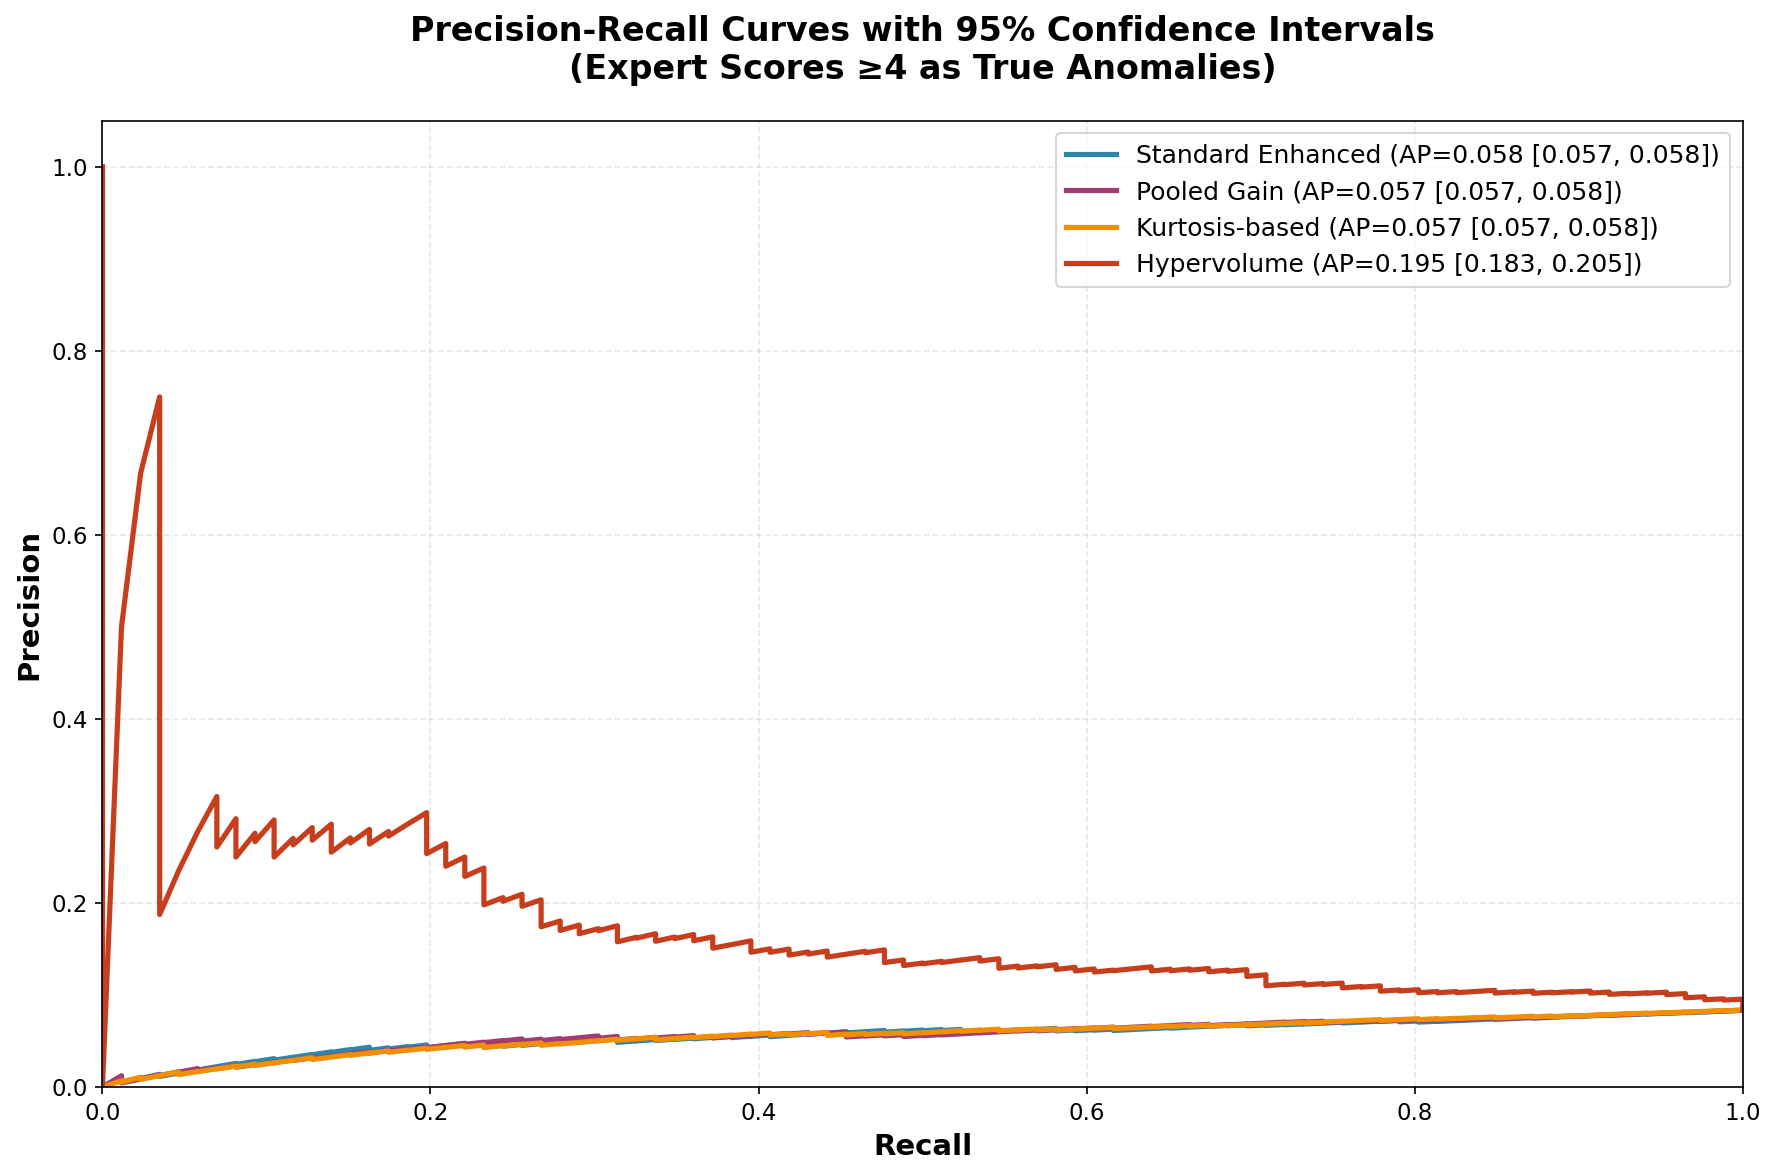

Saved: Figure_PR_Curves_Enhanced.png


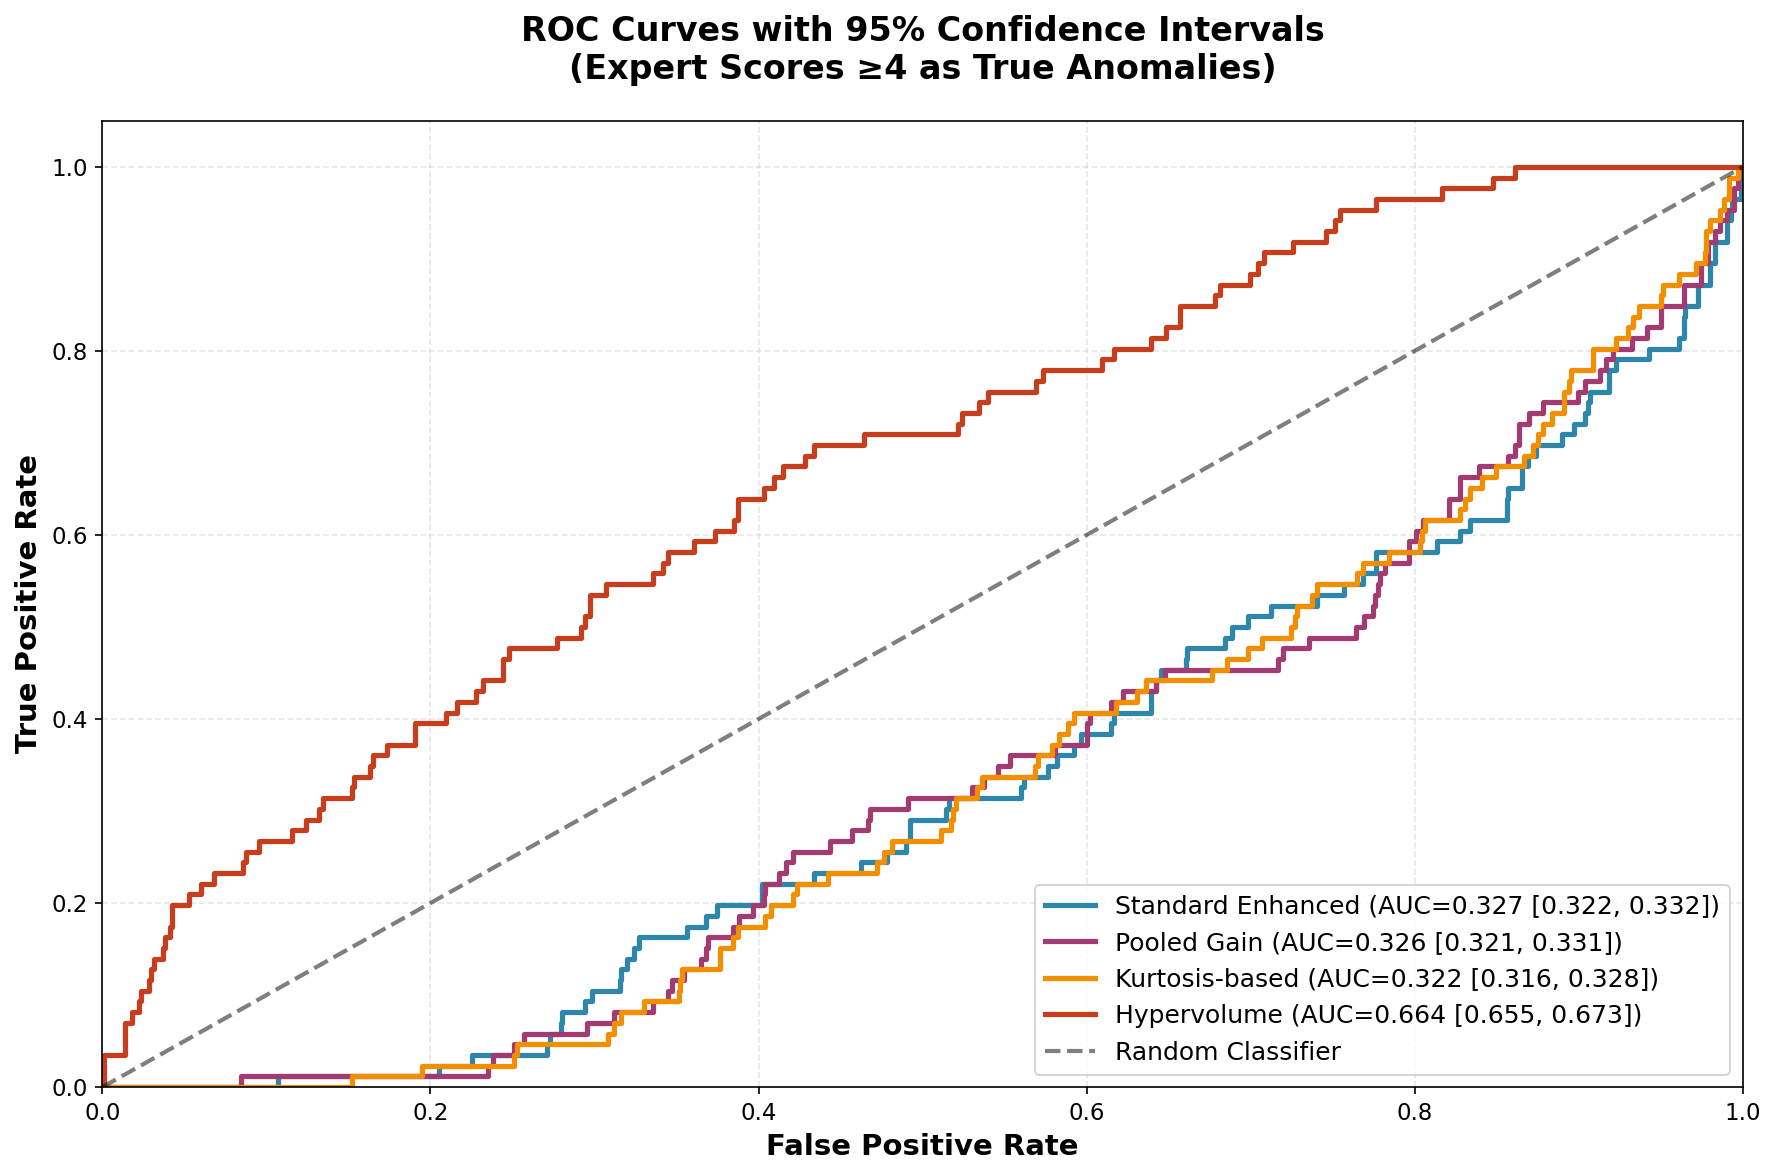

Saved: Figure_ROC_Curves_Enhanced.png


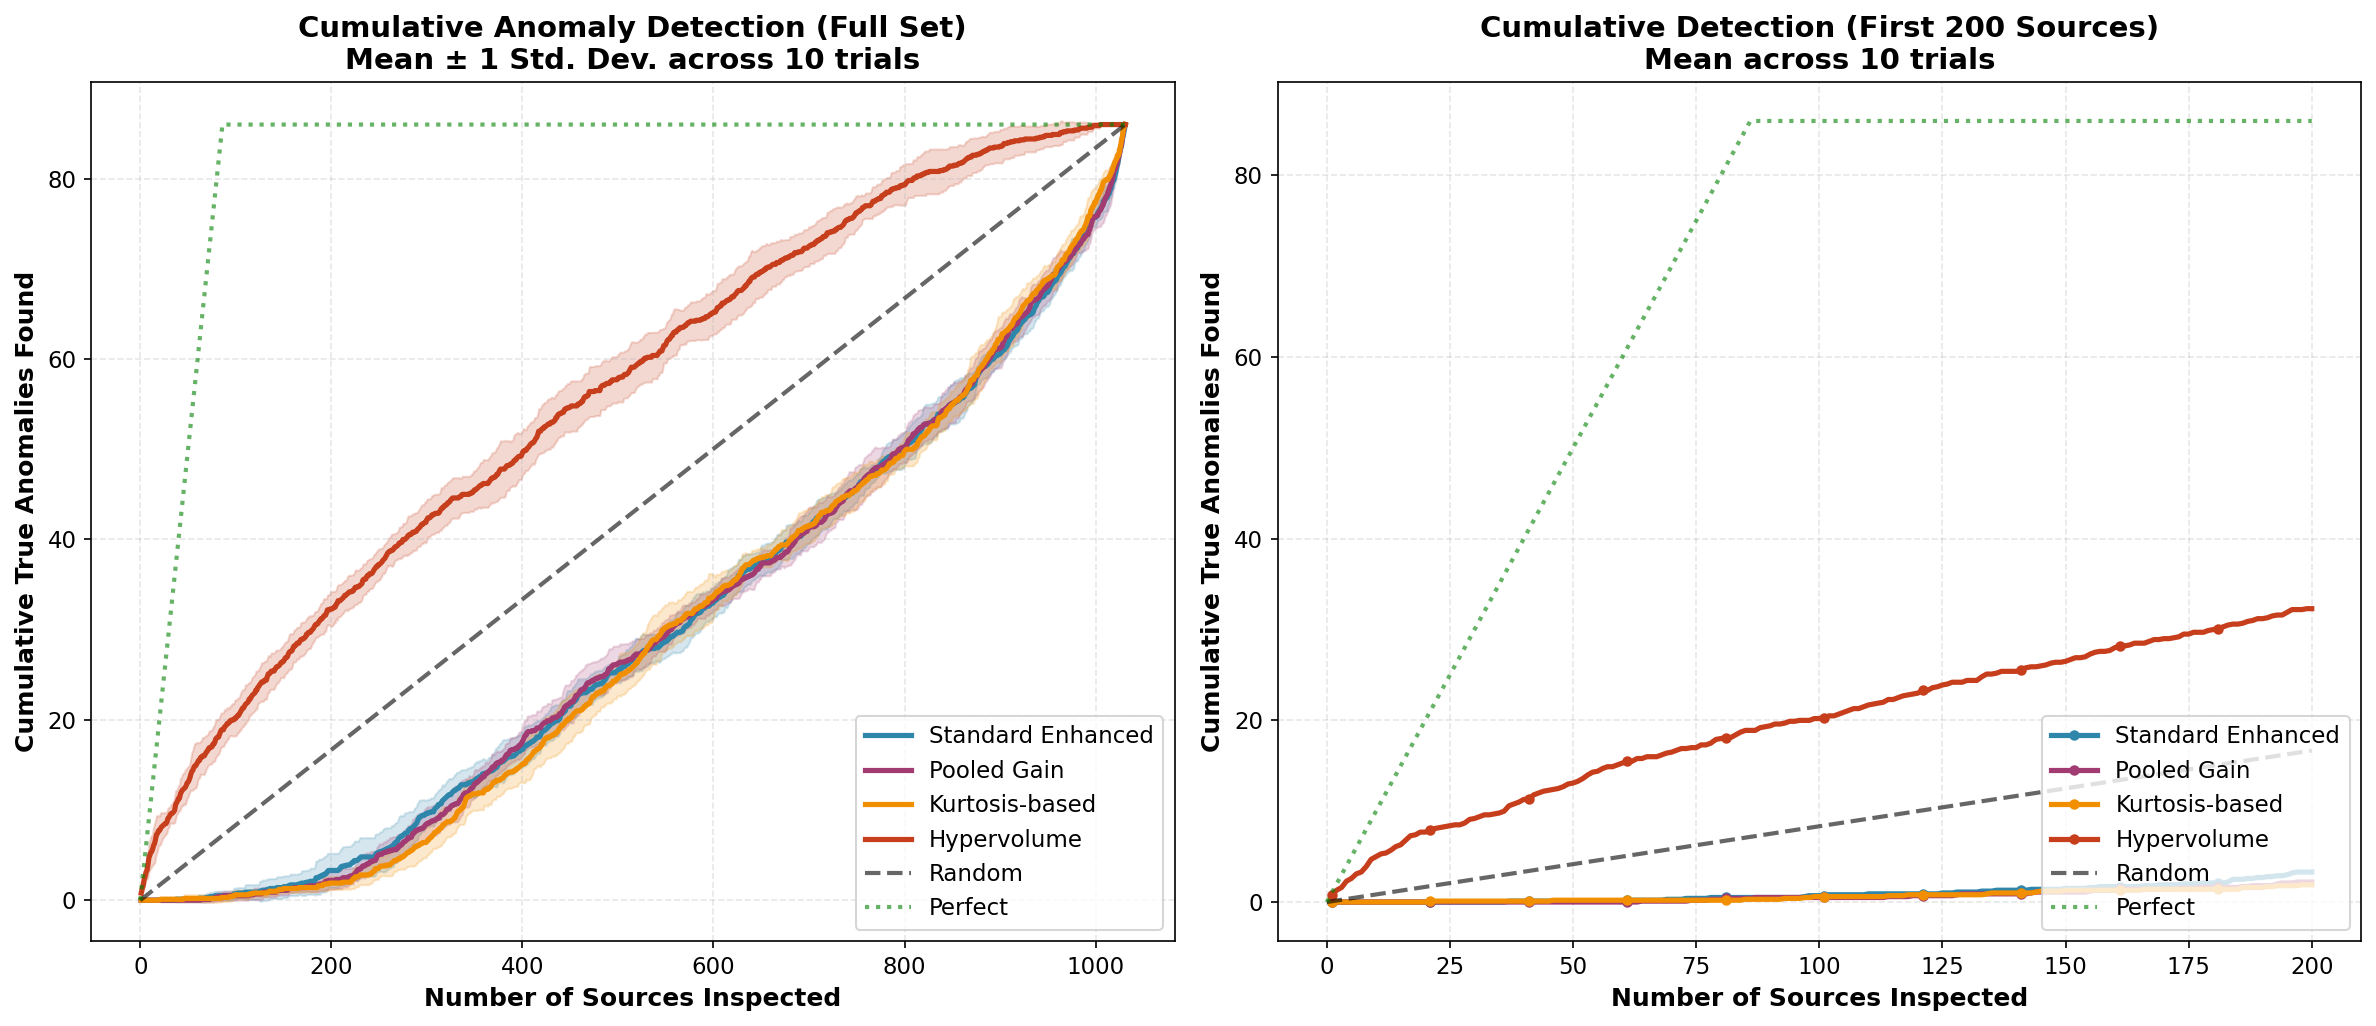

Saved: Figure_Cumulative_Detection_Enhanced.png


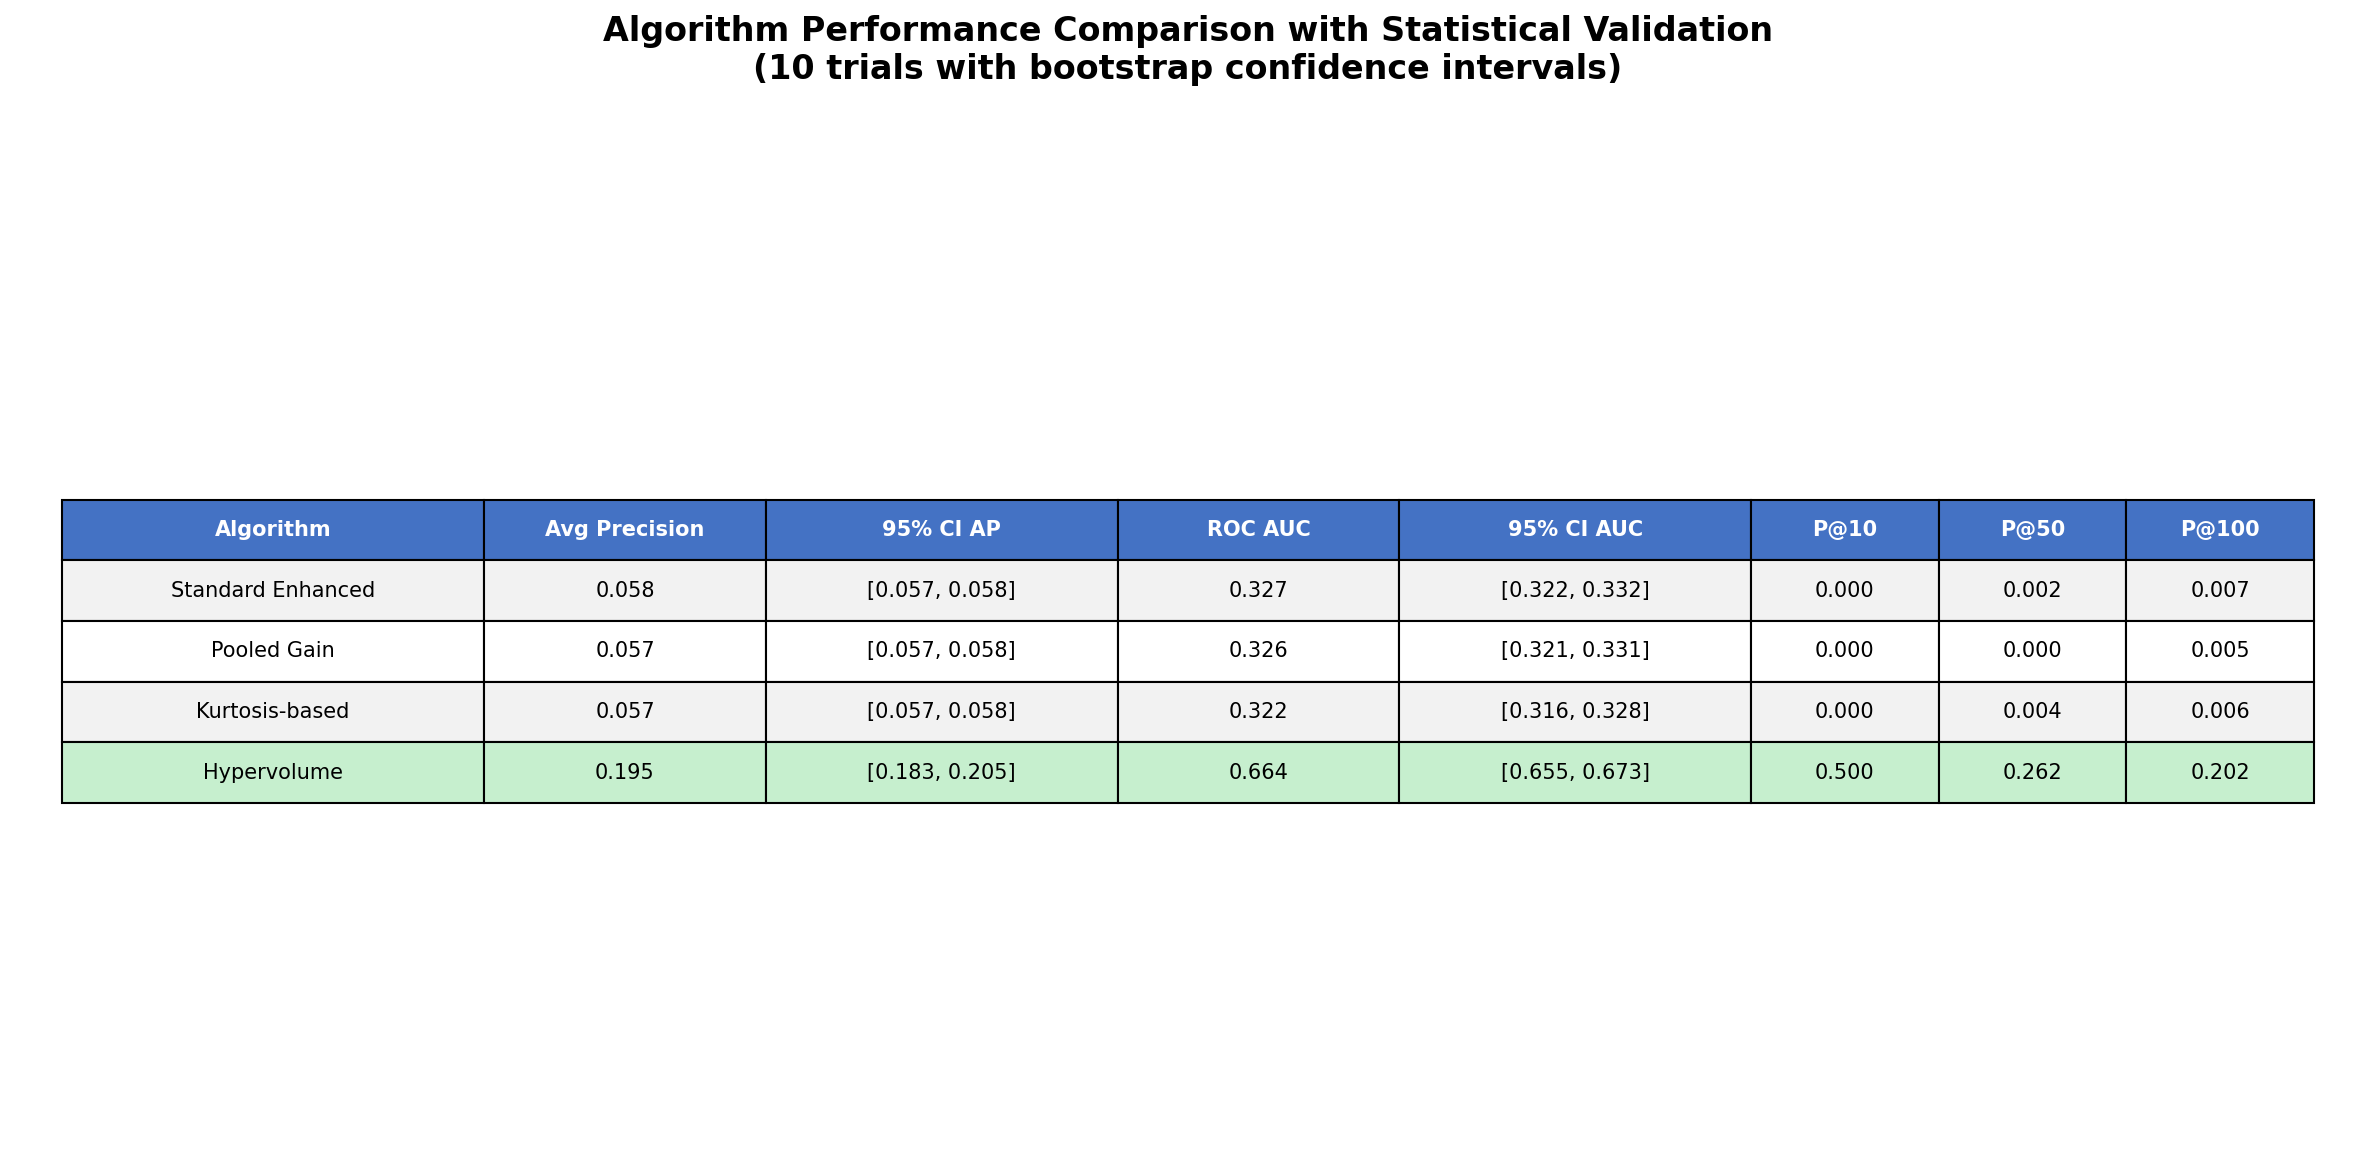

Saved: Figure_Statistical_Performance_Table.png

COMPREHENSIVE EVALUATION RESULTS SUMMARY

BEST PERFORMING ALGORITHMS:
  Average Precision: Hypervolume (0.195)
  ROC AUC: Hypervolume (0.664)
  Precision@10: Hypervolume (0.500)

PERFORMANCE IMPROVEMENT OVER STANDARD:
  Pooled Gain: -0.2% AP improvement
  Kurtosis-based: -0.8% AP improvement
  Hypervolume: +238.6% AP improvement

STATISTICAL SIGNIFICANCE (α=0.05):
  Standard Enhanced_vs_Hypervolume: AP difference is statistically significant (p=0.0000)
  Pooled Gain_vs_Hypervolume: AP difference is statistically significant (p=0.0000)
  Kurtosis-based_vs_Hypervolume: AP difference is statistically significant (p=0.0000)

PRACTICAL IMPLICATIONS:
  Best P@10: 0.500 vs Random: 0.083
  Efficiency gain: 6.0x over random selection
  Astronomers find 5.0 anomalies in top 10 vs 0.8 by chance

EXPORTING RESULTS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All enhanced figures downloaded!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numerical results summary downloaded!

EVALUATION COMPLETE - ALL RESULTS EXPORTED


In [17]:
def create_enhanced_precision_recall_figure(all_trial_results, bootstrap_results):
    """Precision-Recall curves with confidence intervals"""

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    for i, (name, trial_metrics_list) in enumerate(all_trial_results.items()):
        # Use first trial for curve (all are similar)
        precision = trial_metrics_list[0]['precision']
        recall = trial_metrics_list[0]['recall']
        mean_ap = bootstrap_results[name]['mean_ap']
        ci_ap = bootstrap_results[name]['ci_ap']

        ax.plot(recall, precision, color=colors[i], linewidth=2.5,
                label=f"{name} (AP={mean_ap:.3f} [{ci_ap[0]:.3f}, {ci_ap[1]:.3f}])")

    ax.set_xlabel('Recall', fontweight='bold', fontsize=14)
    ax.set_ylabel('Precision', fontweight='bold', fontsize=14)
    ax.set_title('Precision-Recall Curves with 95% Confidence Intervals\n(Expert Scores ≥4 as True Anomalies)',
                 fontweight='bold', fontsize=16, pad=20)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig('Figure_PR_Curves_Enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_PR_Curves_Enhanced.png")
    return fig

def create_enhanced_roc_figure(all_trial_results, bootstrap_results):
    """ROC curves with confidence intervals"""

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    for i, (name, trial_metrics_list) in enumerate(all_trial_results.items()):
        # Use first trial for curve
        fpr = trial_metrics_list[0]['fpr']
        tpr = trial_metrics_list[0]['tpr']
        mean_auc = bootstrap_results[name]['mean_auc']
        ci_auc = bootstrap_results[name]['ci_auc']

        ax.plot(fpr, tpr, color=colors[i], linewidth=2.5,
                label=f"{name} (AUC={mean_auc:.3f} [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random Classifier')

    ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)
    ax.set_title('ROC Curves with 95% Confidence Intervals\n(Expert Scores ≥4 as True Anomalies)',
                 fontweight='bold', fontsize=16, pad=20)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig('Figure_ROC_Curves_Enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_ROC_Curves_Enhanced.png")
    return fig

def create_enhanced_cumulative_detection(all_trial_results, true_labels):
    """Cumulative detection with multiple trials"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    total_anomalies = np.sum(true_labels)
    n_sources = len(true_labels)

    # Full plot
    for i, (name, trial_metrics_list) in enumerate(all_trial_results.items()):
        # Plot mean across trials with shaded CI
        all_cumulative = np.array([metrics['cumulative_tp'] for metrics in trial_metrics_list])
        mean_cumulative = np.mean(all_cumulative, axis=0)
        std_cumulative = np.std(all_cumulative, axis=0)
        positions = trial_metrics_list[0]['positions']

        ax1.plot(positions, mean_cumulative, color=colors[i], linewidth=2.5, label=name)
        ax1.fill_between(positions,
                        mean_cumulative - std_cumulative,
                        mean_cumulative + std_cumulative,
                        color=colors[i], alpha=0.2)

    # Reference lines
    ax1.plot([0, n_sources], [0, total_anomalies], 'k--', alpha=0.6, linewidth=2, label='Random')
    ax1.plot([0, total_anomalies, n_sources], [0, total_anomalies, total_anomalies],
             'g:', alpha=0.6, linewidth=2, label='Perfect')

    ax1.set_xlabel('Number of Sources Inspected', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Cumulative True Anomalies Found', fontweight='bold', fontsize=12)
    ax1.set_title('Cumulative Anomaly Detection (Full Set)\nMean ± 1 Std. Dev. across 10 trials',
                  fontweight='bold', fontsize=14)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3, linestyle='--')

    # Zoomed plot (first 200)
    zoom = 200
    for i, (name, trial_metrics_list) in enumerate(all_trial_results.items()):
        all_cumulative = np.array([metrics['cumulative_tp'] for metrics in trial_metrics_list])
        mean_cumulative = np.mean(all_cumulative, axis=0)
        positions = trial_metrics_list[0]['positions']

        ax2.plot(positions[:zoom], mean_cumulative[:zoom],
                color=colors[i], linewidth=2.5, label=name, marker='o',
                markersize=4, markevery=20)

    random_rate = total_anomalies / n_sources
    ax2.plot([0, zoom], [0, zoom * random_rate], 'k--', alpha=0.6, linewidth=2, label='Random')
    perfect_at_zoom = min(total_anomalies, zoom)
    ax2.plot([0, perfect_at_zoom, zoom], [0, perfect_at_zoom, perfect_at_zoom],
             'g:', alpha=0.6, linewidth=2, label='Perfect')

    ax2.set_xlabel('Number of Sources Inspected', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Cumulative True Anomalies Found', fontweight='bold', fontsize=12)
    ax2.set_title(f'Cumulative Detection (First {zoom} Sources)\nMean across 10 trials',
                  fontweight='bold', fontsize=14)
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('Figure_Cumulative_Detection_Enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_Cumulative_Detection_Enhanced.png")
    return fig

def create_statistical_performance_table(bootstrap_results, significance_results):
    """Comprehensive performance table with statistical significance"""

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('off')

    # Prepare table data
    table_data = []
    algorithms = list(bootstrap_results.keys())

    for name in algorithms:
        stats = bootstrap_results[name]
        table_data.append([
            name,
            f"{stats['mean_ap']:.3f}",
            f"[{stats['ci_ap'][0]:.3f}, {stats['ci_ap'][1]:.3f}]",
            f"{stats['mean_auc']:.3f}",
            f"[{stats['ci_auc'][0]:.3f}, {stats['ci_auc'][1]:.3f}]",
            f"{stats['mean_p10']:.3f}",
            f"{stats['mean_p50']:.3f}",
            f"{stats['mean_p100']:.3f}"
        ])

    table = ax.table(
        cellText=table_data,
        colLabels=['Algorithm', 'Avg Precision', '95% CI AP', 'ROC AUC', '95% CI AUC',
                  'P@10', 'P@50', 'P@100'],
        cellLoc='center',
        loc='center',
        colWidths=[0.18, 0.12, 0.15, 0.12, 0.15, 0.08, 0.08, 0.08]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)

    # Header formatting
    for i in range(8):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Row formatting and highlight best
    ap_values = [bootstrap_results[name]['mean_ap'] for name in algorithms]
    best_ap_idx = np.argmax(ap_values)

    for i, name in enumerate(algorithms):
        for j in range(8):
            color = '#F2F2F2' if i % 2 == 0 else 'white'
            if i == best_ap_idx:
                color = '#C6EFCE'  # Highlight best AP
            table[(i + 1, j)].set_facecolor(color)

    ax.set_title('Algorithm Performance Comparison with Statistical Validation\n'
                '(10 trials with bootstrap confidence intervals)',
                fontweight='bold', fontsize=16, pad=30)

    plt.tight_layout()
    plt.savefig('Figure_Statistical_Performance_Table.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_Statistical_Performance_Table.png")
    return fig

# Generate all enhanced figures
print("\n FIGURES WITH STATISTICAL VALIDATION")
print("=" * 55)

fig_pr_enhanced = create_enhanced_precision_recall_figure(all_trial_results, bootstrap_results)
fig_roc_enhanced = create_enhanced_roc_figure(all_trial_results, bootstrap_results)
fig_cum_enhanced = create_enhanced_cumulative_detection(all_trial_results, true_labels)
fig_table_enhanced = create_statistical_performance_table(bootstrap_results, significance_results)

"""# STEP 7: COMPREHENSIVE RESULTS SUMMARY"""

def generate_comprehensive_summary(bootstrap_results, significance_results):
    """Generate detailed results summary"""

    print("\n" + "="*70)
    print("COMPREHENSIVE EVALUATION RESULTS SUMMARY")
    print("="*70)

    # Find best algorithm
    best_ap_alg = max(bootstrap_results.items(), key=lambda x: x[1]['mean_ap'])
    best_auc_alg = max(bootstrap_results.items(), key=lambda x: x[1]['mean_auc'])
    best_p10_alg = max(bootstrap_results.items(), key=lambda x: x[1]['mean_p10'])

    print(f"\nBEST PERFORMING ALGORITHMS:")
    print(f"  Average Precision: {best_ap_alg[0]} ({best_ap_alg[1]['mean_ap']:.3f})")
    print(f"  ROC AUC: {best_auc_alg[0]} ({best_auc_alg[1]['mean_auc']:.3f})")
    print(f"  Precision@10: {best_p10_alg[0]} ({best_p10_alg[1]['mean_p10']:.3f})")

    print(f"\nPERFORMANCE IMPROVEMENT OVER STANDARD:")
    standard_ap = bootstrap_results['Standard Enhanced']['mean_ap']
    for name, stats in bootstrap_results.items():
        if name != 'Standard Enhanced':
            improvement = ((stats['mean_ap'] - standard_ap) / standard_ap) * 100
            print(f"  {name}: {improvement:+.1f}% AP improvement")

    print(f"\nSTATISTICAL SIGNIFICANCE (α=0.05):")
    significant_pairs = [pair for pair, results in significance_results.items()
                        if results['AP_significant'] or results['AUC_significant']]

    if significant_pairs:
        for pair in significant_pairs:
            results = significance_results[pair]
            if results['AP_significant']:
                print(f"  {pair}: AP difference is statistically significant (p={results['AP_p-value']:.4f})")
    else:
        print("  No statistically significant differences found at α=0.05")

    print(f"\nPRACTICAL IMPLICATIONS:")
    best_p10 = best_p10_alg[1]['mean_p10']
    random_p10 = np.sum(true_labels) / len(true_labels)
    efficiency_gain = (best_p10 / random_p10) if random_p10 > 0 else float('inf')
    print(f"  Best P@10: {best_p10:.3f} vs Random: {random_p10:.3f}")
    print(f"  Efficiency gain: {efficiency_gain:.1f}x over random selection")
    print(f"  Astronomers find {best_p10*10:.1f} anomalies in top 10 vs {random_p10*10:.1f} by chance")

# Generate summary
generate_comprehensive_summary(bootstrap_results, significance_results)

"""# STEP 8: EXPORT ALL RESULTS"""

print("\nEXPORTING RESULTS")
print("=" * 20)

# Download all figures
files.download('Figure_PR_Curves_Enhanced.png')
files.download('Figure_ROC_Curves_Enhanced.png')
files.download('Figure_Cumulative_Detection_Enhanced.png')
files.download('Figure_Statistical_Performance_Table.png')

print("\nAll enhanced figures downloaded!")

# Save numerical results to CSV
results_df = pd.DataFrame({
    'Algorithm': list(bootstrap_results.keys()),
    'Mean_AP': [bootstrap_results[alg]['mean_ap'] for alg in bootstrap_results.keys()],
    'AP_CI_Lower': [bootstrap_results[alg]['ci_ap'][0] for alg in bootstrap_results.keys()],
    'AP_CI_Upper': [bootstrap_results[alg]['ci_ap'][1] for alg in bootstrap_results.keys()],
    'Mean_AUC': [bootstrap_results[alg]['mean_auc'] for alg in bootstrap_results.keys()],
    'AUC_CI_Lower': [bootstrap_results[alg]['ci_auc'][0] for alg in bootstrap_results.keys()],
    'AUC_CI_Upper': [bootstrap_results[alg]['ci_auc'][1] for alg in bootstrap_results.keys()],
    'P@10': [bootstrap_results[alg]['mean_p10'] for alg in bootstrap_results.keys()],
    'P@50': [bootstrap_results[alg]['mean_p50'] for alg in bootstrap_results.keys()],
    'P@100': [bootstrap_results[alg]['mean_p100'] for alg in bootstrap_results.keys()]
})

results_df.to_csv('Statistical_Results_Summary.csv', index=False)
files.download('Statistical_Results_Summary.csv')

print("Numerical results summary downloaded!")
print("\nEVALUATION COMPLETE - ALL RESULTS EXPORTED")
